In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Подготовка изображений

In [2]:
import pathlib
data_dir = "/Users/admin/PIS/DZ/data"

data_dir = pathlib.Path(data_dir)

In [3]:
data_dir

PosixPath('/Users/admin/PIS/DZ/data')

## Количество изображений в датасете

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.jpeg'))) + len(list(data_dir.glob('*/*.png')))
image_count

450

## Количество классов в датасете

In [5]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"])
CLASS_NAMES

array(['Viral Pneumonia', 'Normal', 'Covid'], dtype='<U15')

## Выведем по одному изображению каждого класса

In [6]:
from IPython.display import Image

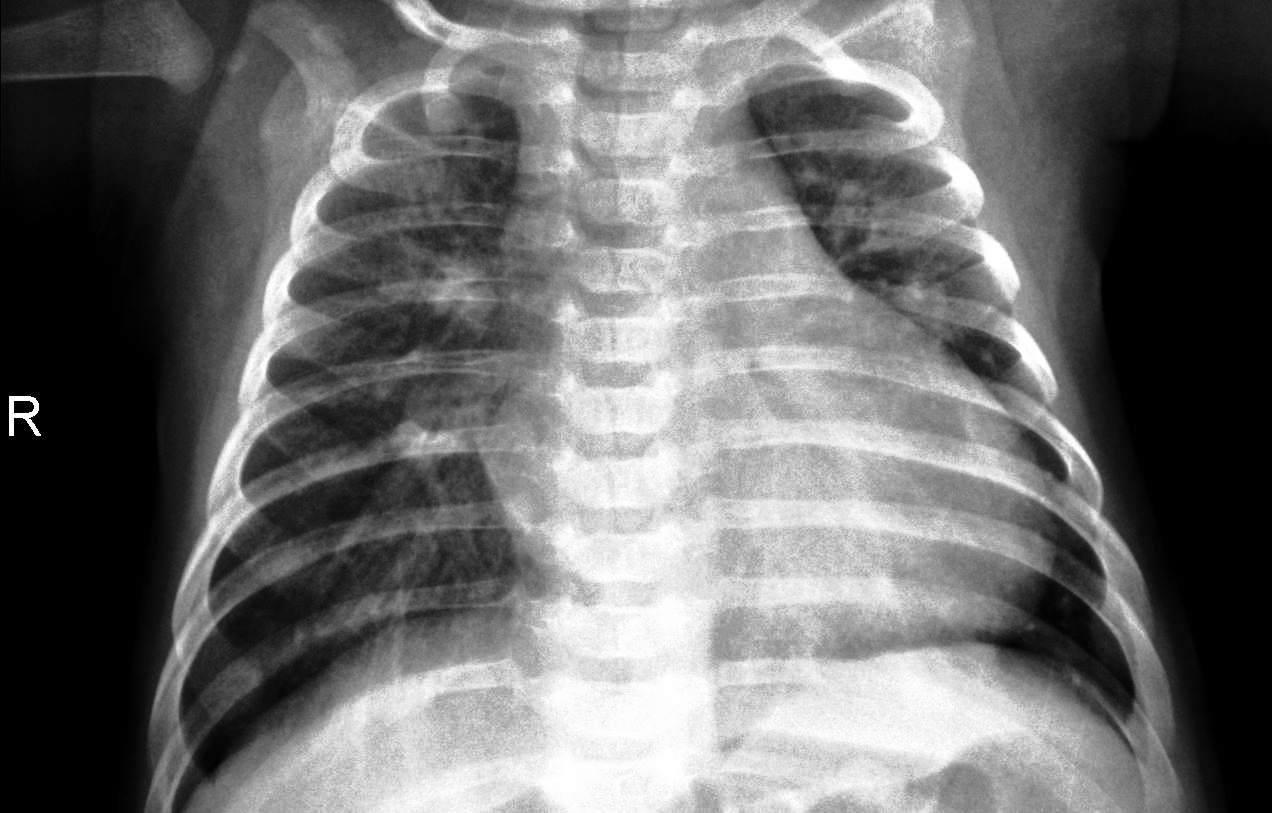

In [7]:
pneumo = list(data_dir.glob('Viral Pneumonia/*'))
Image(filename=pneumo[0]) 

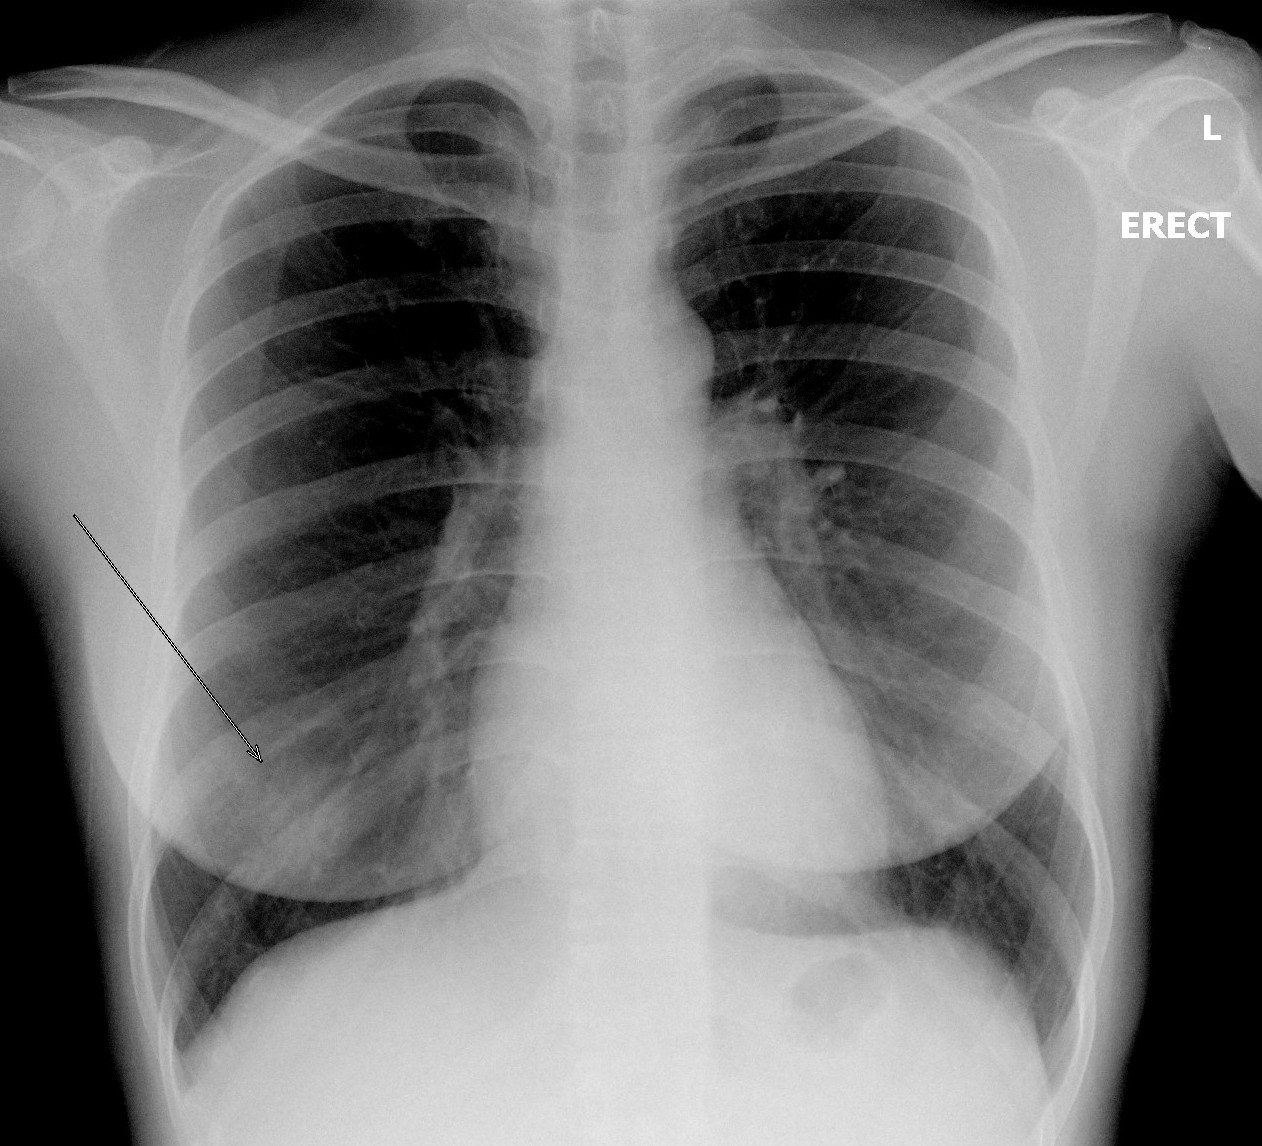

In [8]:
covid = list(data_dir.glob('Covid/*'))
Image(filename=covid[0])

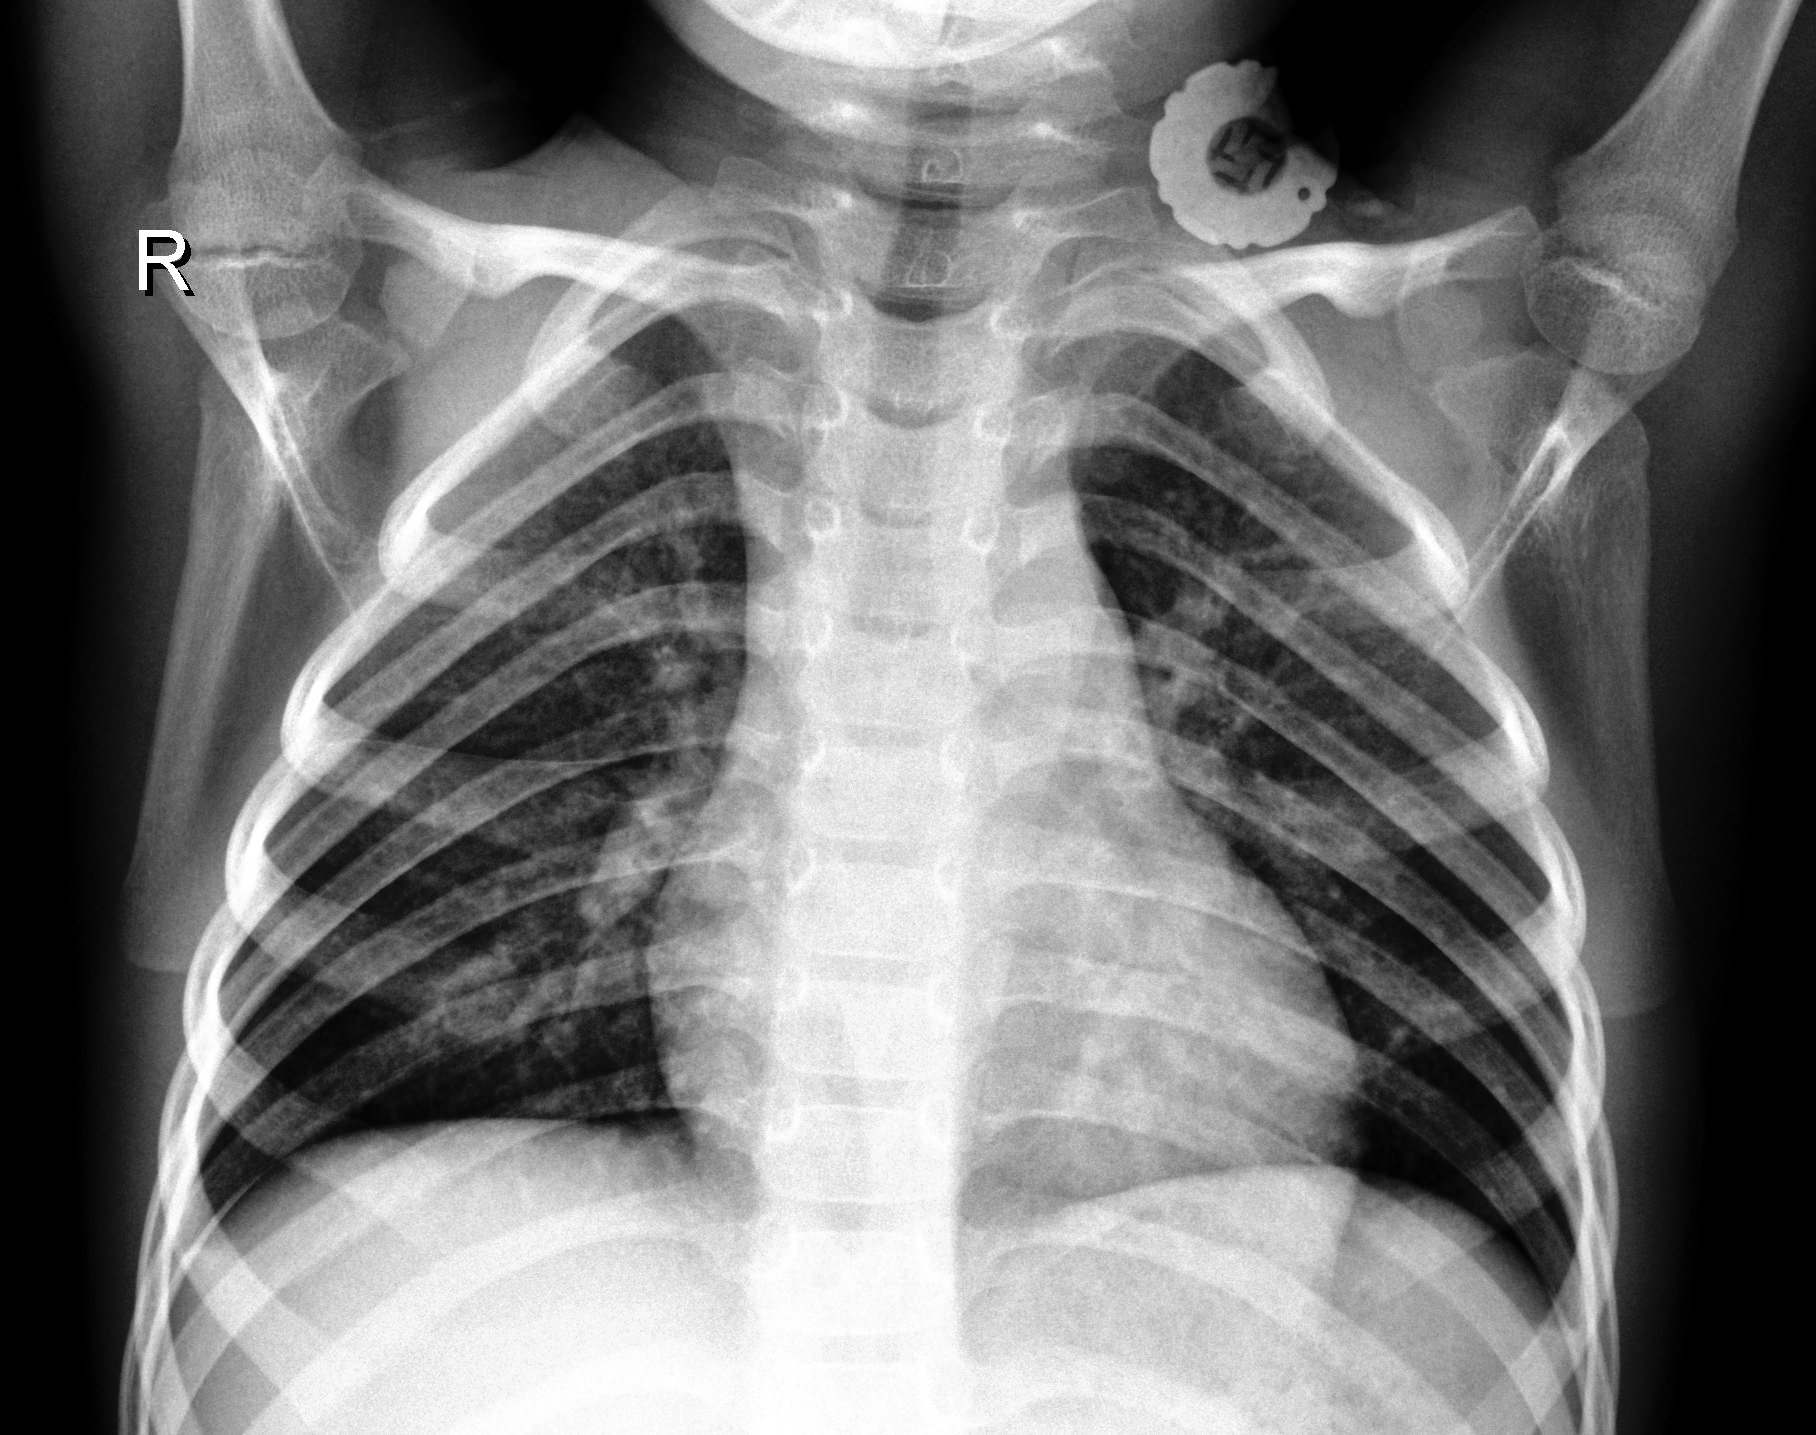

In [9]:
normal = list(data_dir.glob('Normal/*'))
Image(filename=normal[0])

In [10]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [11]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [12]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     subset='training')

Found 361 images belonging to 3 classes.


In [13]:
validation_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     subset='validation')

Found 89 images belonging to 3 classes.


In [14]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

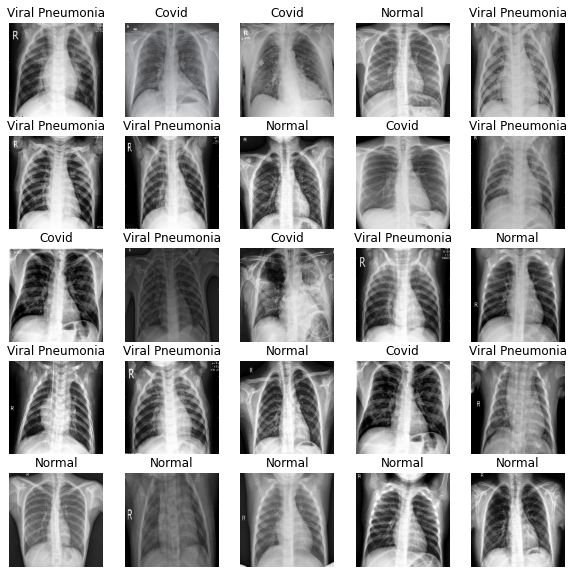

In [15]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [16]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

## В качестве модели выберем MobileNetV2

In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [18]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [19]:
base_model.trainable = False

In [20]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


## Настроим сохранение модели

In [23]:
import os
checkpoint_path="training/cp.pkt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [24]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
len(model.trainable_variables)

2

In [30]:
initial_epochs = 6
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_data_gen, steps = validation_steps)

20/20 [==============================] - 24s 1s/step - loss: 0.8332 - accuracy: 0.2140


In [31]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.83
initial accuracy: 0.21


In [32]:
history = model.fit(train_data_gen,
                    steps_per_epoch = train_data_gen.samples,
                    epochs=initial_epochs,
                    callbacks=[cp_callback],
                    validation_data=validation_data_gen, 
                    validation_steps = validation_data_gen.samples)

Epoch 1/6
361/361 [==============================] - ETA: 0s - loss: 0.4109 - accuracy: 0.7724
Epoch 00001: saving model to training/cp.pkt
361/361 [==============================] - 478s 1s/step - loss: 0.4109 - accuracy: 0.7724 - val_loss: 0.3315 - val_accuracy: 0.8091
Epoch 2/6
361/361 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.9357
Epoch 00002: saving model to training/cp.pkt
361/361 [==============================] - 471s 1s/step - loss: 0.1990 - accuracy: 0.9357 - val_loss: 0.2707 - val_accuracy: 0.8537
Epoch 3/6
361/361 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.9606
Epoch 00003: saving model to training/cp.pkt
361/361 [==============================] - 482s 1s/step - loss: 0.1361 - accuracy: 0.9606 - val_loss: 0.2457 - val_accuracy: 0.8647
Epoch 4/6
361/361 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9785
Epoch 00004: saving model to training/cp.pkt
361/361 [==============================] - 4

In [33]:
model.save('my_model.h5')

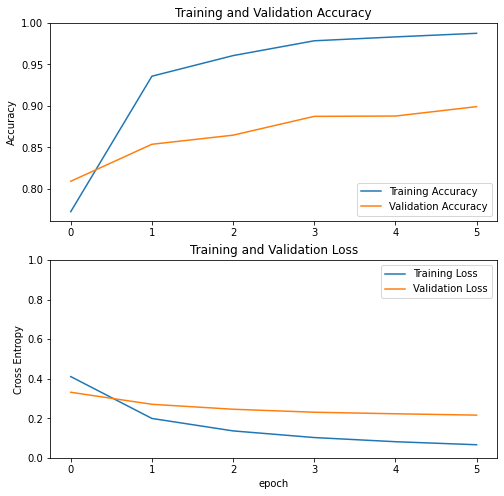

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Код для восстановления модели

In [ ]:
model.load_weights(checkpoint_path)
loss, accuracy = model.evaluate(validation_data_gen)

      2/Unknown - 1s 568ms/step - loss: 0.2136 - accuracy: 0.9062

### Из файла h5

In [ ]:
new_model = tf.keras.models.load_model('my_model.h5')